In [ ]:
# %%

import numpy as np
import matplotlib.pyplot as plt
from shared_simulator import (
    NodeReputationSimulator, 
    NodeReliability, 
    NetworkSimulator,
    run_notebook_simulation,
    scenario_reliable_then_failing,
    scenario_gradual_degradation
)

# by default make matplotlib use dark mode
# plt.style.use("dark_background")
# make the maplotlibs high dpi
plt.rcParams["figure.dpi"] = 150

# set np random seed for reproducibility
# convert string to seed
seed = "storb"
seed = sum(ord(c) for c in seed) % (2**32 - 1)
np.random.seed(seed)

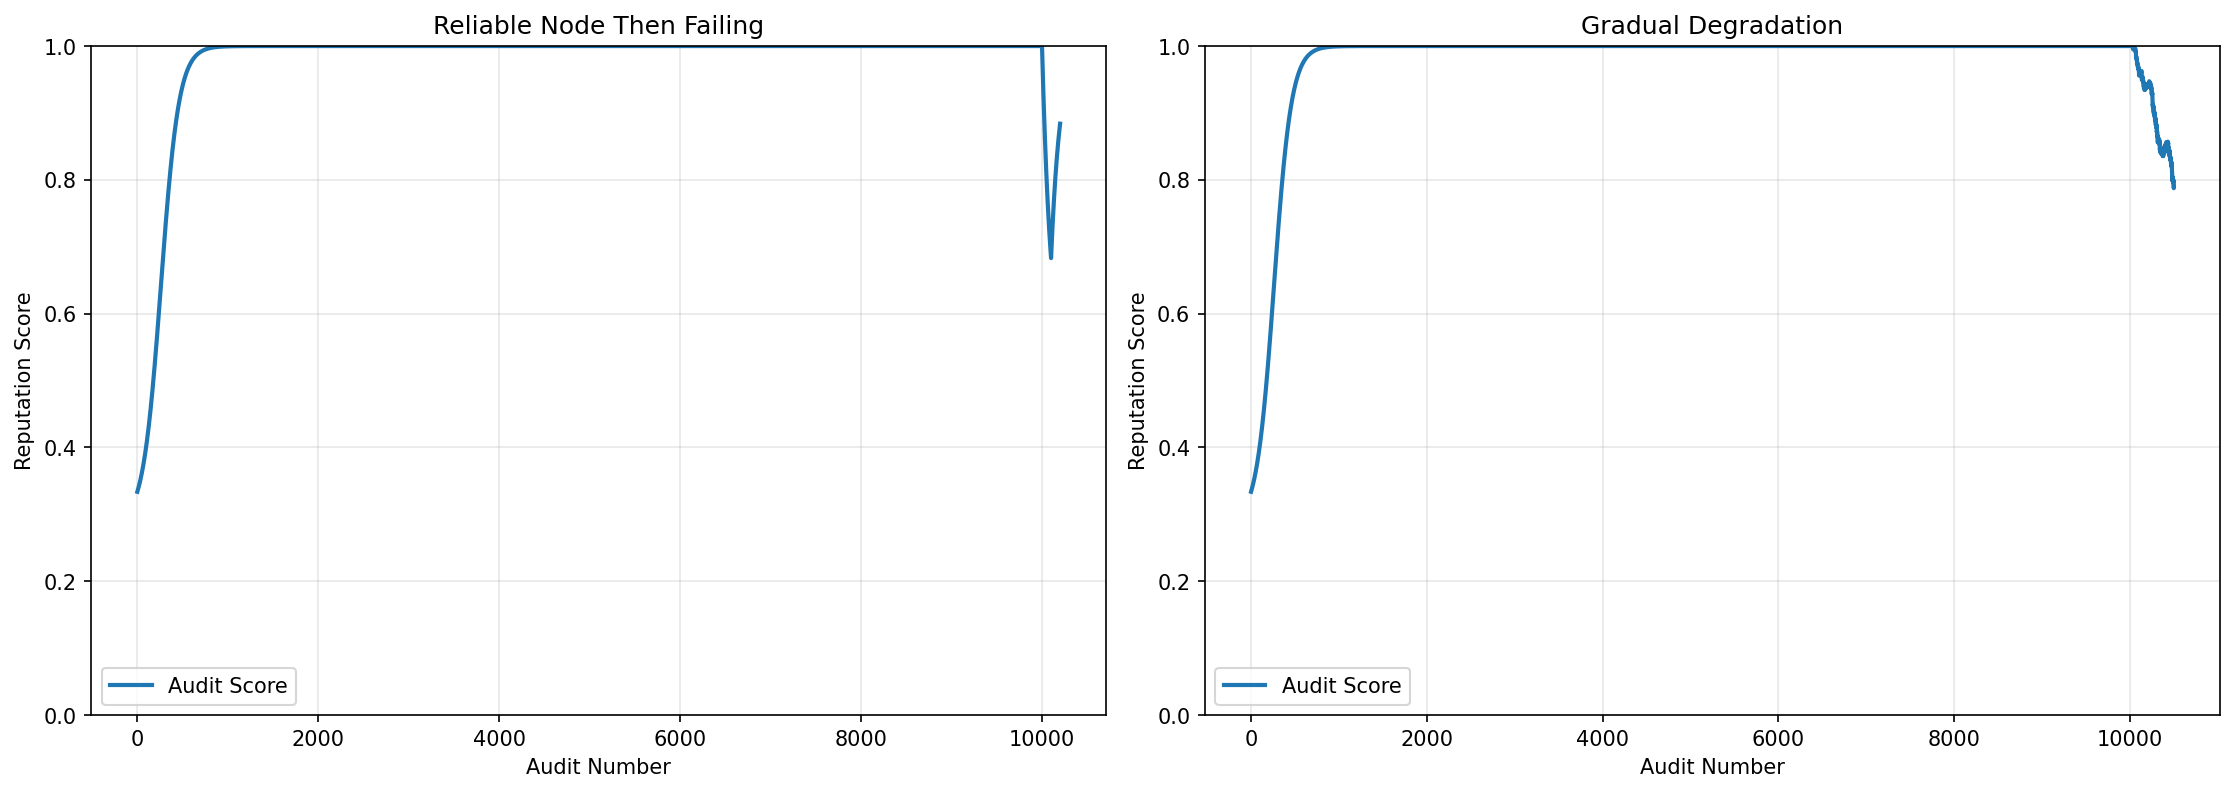

In [ ]:
# %%

# Legacy scenario testing using individual node simulators
def test_individual_node_scenarios():
    """Test individual node scenarios (legacy functionality)"""
    # Create a simulator for individual node testing
    simulator = NodeReputationSimulator()
    
    scenarios = [
        ("Reliable Node Then Failing", scenario_reliable_then_failing()),
        ("Gradual Degradation", scenario_gradual_degradation()),
    ]

    plt.figure(figsize=(15, 10))

    for i, (name, events) in enumerate(scenarios):
        # Reset simulator for each scenario
        simulator.__init__()
        
        # Simulate events
        for event in events:
            simulator.apply_audit_result(event["type"])

        plt.subplot(2, 2, i + 1)
        audit_scores = [h["audit_score"] for h in simulator.history]

        plt.plot(audit_scores, label="Audit Score", linewidth=2)

        plt.title(name)
        plt.xlabel("Audit Number")
        plt.ylabel("Reputation Score")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Run the individual scenario tests
test_individual_node_scenarios()

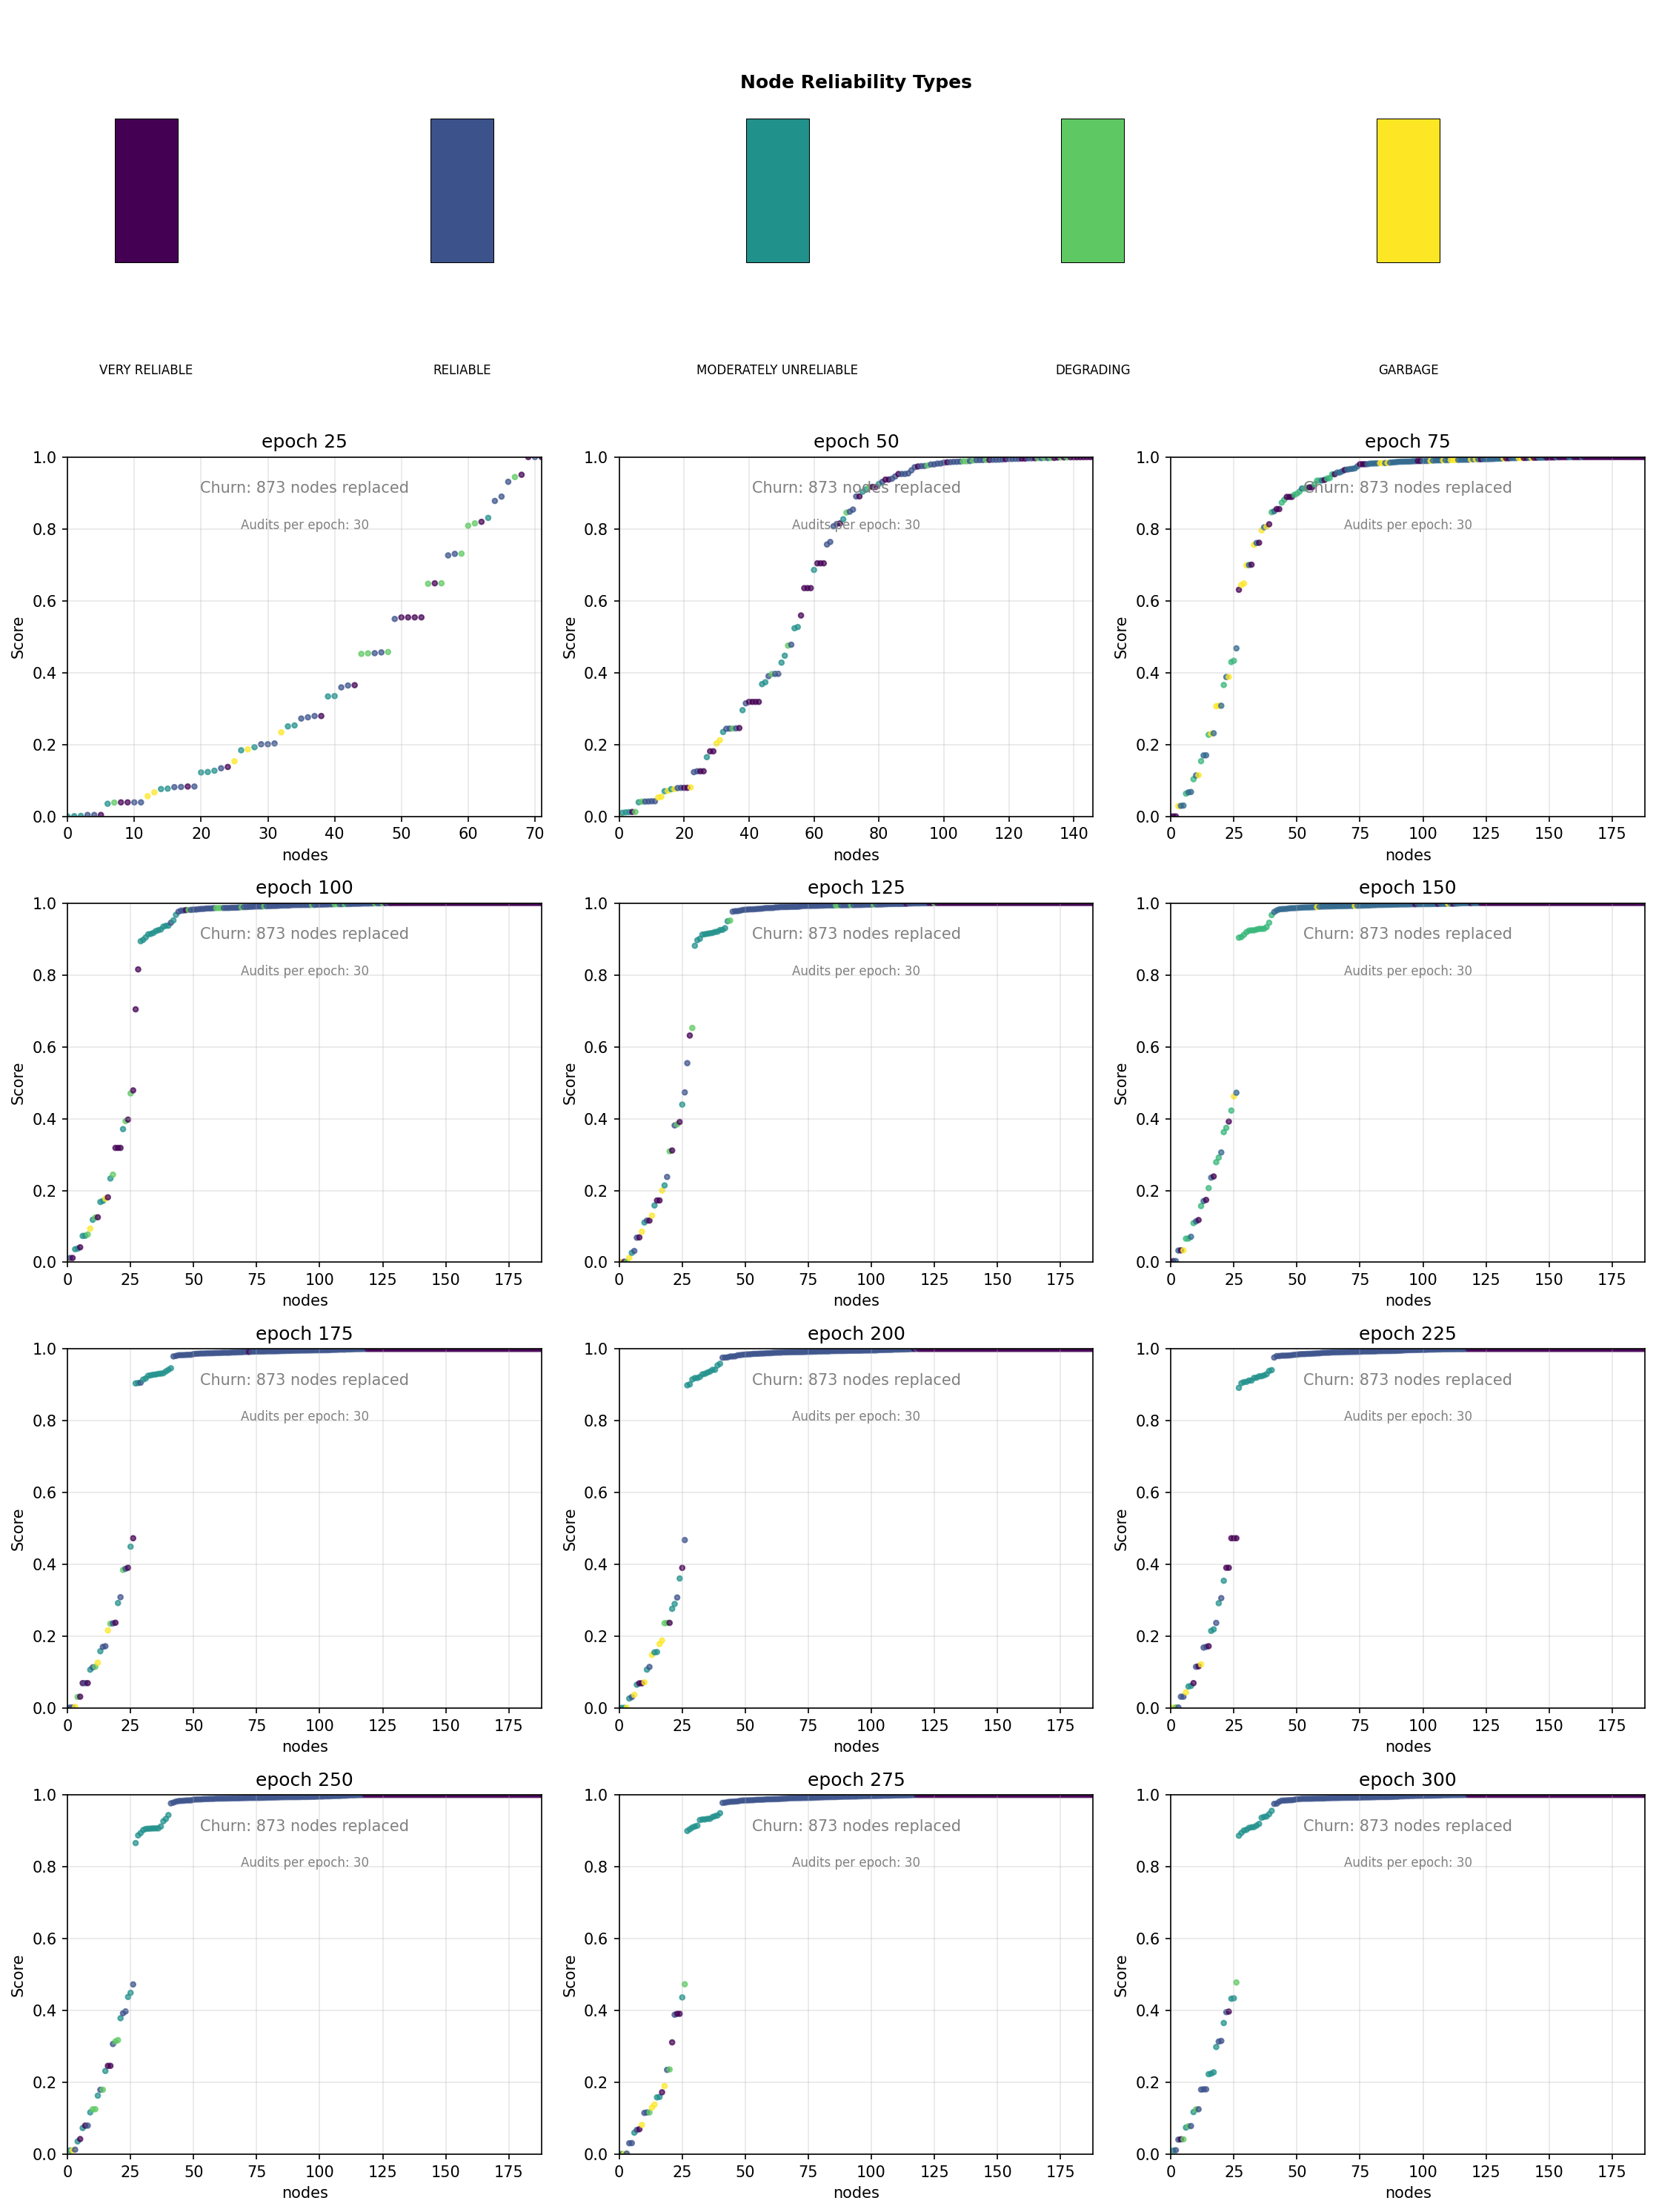

In [ ]:
# %%

def plot_network_simulation_snapshots():
    """Run network simulation and plot snapshots at different epochs with sorted node scores"""
    
    # Run simulation with new zero-start behavior
    config = {
        "num_nodes_target": 192,
        "epochs": 300,
        "audits_per_epoch": 30,
        "nodes_per_epoch_add": 3,
        "nodes_per_epoch_churn": 3,
        "min_epochs_before_churn": 10
    }
    
    result = run_notebook_simulation(config)
    epoch_data = result["epoch_data"]
    churn_events = result["churn_events"]
    
    # Plot snapshots at specific epochs to match notebook style
    epochs_to_plot = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
    
    # Create snapshot plots
    num_plots = len(epochs_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    fig = plt.figure(figsize=(15, 5 * num_rows))
    
    # Create reliability color mapping and legend
    reliability_map = {
        "VERY_RELIABLE": 1,
        "RELIABLE": 2, 
        "MODERATELY_UNRELIABLE": 3,
        "DEGRADING": 4,
        "GARBAGE": 5
    }
    
    # Create a colorbar/legend at the top of the figure
    # Add a subplot at the top for the legend
    legend_ax = fig.add_subplot(num_rows + 1, 1, 1)
    legend_ax.set_xlim(0, 10)
    legend_ax.set_ylim(0, 1)
    legend_ax.axis('off')
    
    # Create legend elements
    from matplotlib.patches import Rectangle
    import matplotlib.cm as cm
    
    # Get viridis colormap
    viridis = cm._colormaps.get_cmap('viridis')
    
    # Create legend entries
    legend_elements = []
    legend_labels = []
    x_positions = [0.5, 2.5, 4.5, 6.5, 8.5]
    
    for i, (reliability_name, color_value) in enumerate(reliability_map.items()):
        # Normalize color value to 0-1 range for colormap
        normalized_color = (color_value - 1) / 4  # Since values are 1-5
        color = viridis(normalized_color)
        
        # Add colored rectangle
        rect = Rectangle((x_positions[i] - 0.2, 0.3), 0.4, 0.4, 
                        facecolor=color, edgecolor='black', linewidth=0.5)
        legend_ax.add_patch(rect)
        
        # Add text label
        legend_ax.text(x_positions[i], 0.0, reliability_name.replace('_', ' '), 
                      ha='center', va='center', fontsize=8, rotation=0)
    
    # Add title for legend
    legend_ax.text(5, 0.8, 'Node Reliability Types', ha='center', va='center', 
                  fontsize=12, fontweight='bold', color='black')
    
    # Adjust subplot positioning to make room for legend
    # plt.subplots_adjust(top=0.0, hspace=0.0)
    
    for i, target_epoch in enumerate(epochs_to_plot):
        # Find the closest epoch data
        epoch_idx = min(target_epoch - 1, len(epoch_data) - 1)
        if epoch_idx < 0:
            continue
            
        data = epoch_data[epoch_idx]
        # Adjust subplot index to account for legend
        ax = fig.add_subplot(num_rows + 1, num_cols, i + num_cols + 1)
        
        if data["nodes"]:
            # Extract scores and reliability data
            node_scores = [node["y"] for node in data["nodes"]]
            node_reliability = [node["reliability"] for node in data["nodes"]]
            
            # Create tuples of (score, reliability) and sort by score
            node_data = list(zip(node_scores, node_reliability))
            node_data.sort(key=lambda x: x[0])  # Sort by score (ascending)
            
            # Extract sorted data
            sorted_scores = [item[0] for item in node_data]
            sorted_reliability = [item[1] for item in node_data]
            
            # Normalize scores like in the notebook (optional - can be removed if you want raw scores)
            if len(set(sorted_scores)) > 1:  # Avoid division by zero
                min_score = min(sorted_scores)
                max_score = max(sorted_scores)
                normalized_scores = [(score - min_score) / (max_score - min_score) for score in sorted_scores]
            else:
                # All scores are the same
                normalized_scores = [0.0] * len(sorted_scores)
            
            colors = [reliability_map[rel] for rel in sorted_reliability]
            
            # Plot with normalized scores (change to sorted_scores for raw scores)
            scatter = ax.scatter(
                range(len(normalized_scores)),
                normalized_scores,  # or sorted_scores for raw values
                c=colors,
                cmap="viridis",
                s=10,
                alpha=0.7
            )
            
            ax.set_title(f"epoch {data['epoch']}")
            ax.set_xlim(0, len(normalized_scores) - 1)
            ax.set_xlabel("nodes")
            ax.set_ylabel("Score")
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)
            
            # Add statistics text like in notebook
            ax.text(
                0.5,
                0.9,
                f"Churn: {len(churn_events)} nodes replaced",
                transform=ax.transAxes,
                ha="center",
                fontsize=10,
                color="gray",
            )
            ax.text(
                0.5,
                0.8,
                f"Audits per epoch: {config['audits_per_epoch']}",
                transform=ax.transAxes,
                ha="center",
                fontsize=8,
                color="gray",
            )
        else:
            # No nodes yet
            ax.set_title(f"epoch {data['epoch']}")
            ax.set_xlabel("nodes")
            ax.set_ylabel("Score")
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)
            ax.text(0.5, 0.5, "No nodes yet", transform=ax.transAxes, 
                   ha="center", va="center", fontsize=12, color="gray")
    
    plt.tight_layout()
    plt.show()
    
    return result

# Run the network simulation
result = plot_network_simulation_snapshots()

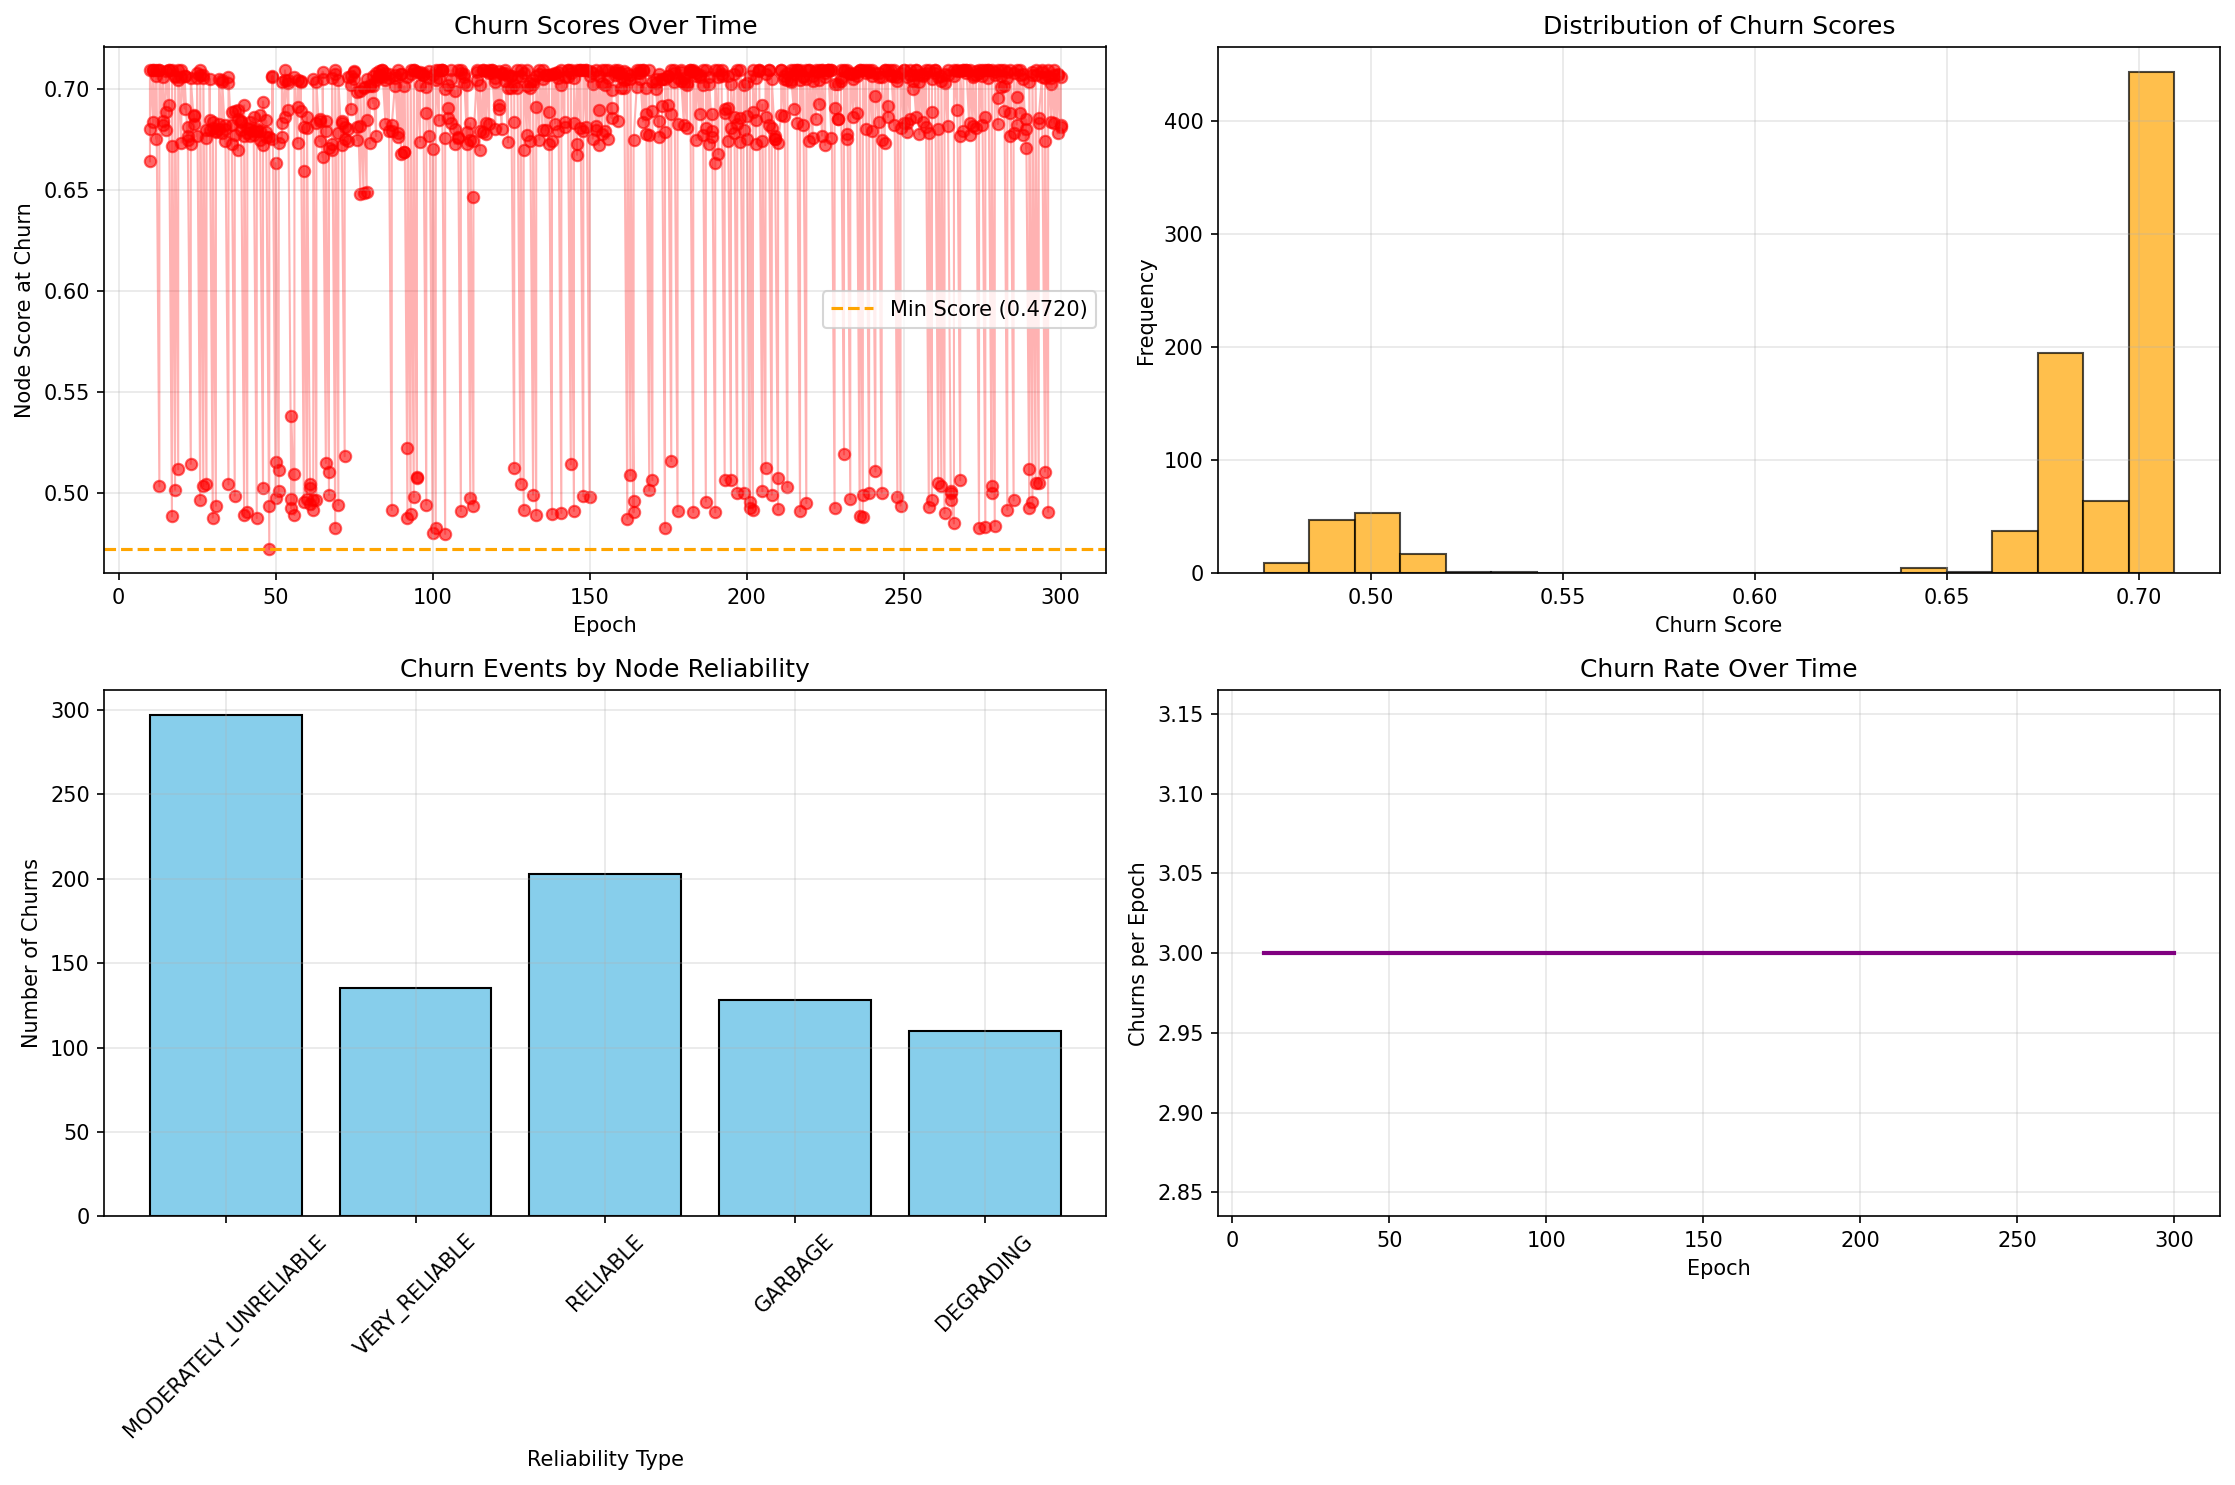


Churn Analysis Summary:
Total churn events: 873
Average churn score: 0.6670
Churn score std dev: 0.0713
Min churn score: 0.4720
Max churn score: 0.7092

Churn by reliability type:
  MODERATELY_UNRELIABLE: 297 (34.0%)
  VERY_RELIABLE: 135 (15.5%)
  RELIABLE: 203 (23.3%)
  GARBAGE: 128 (14.7%)
  DEGRADING: 110 (12.6%)


In [ ]:
# %%

def analyze_churn_patterns(result):
    """Analyze and visualize churn patterns"""
    churn_events = result["churn_events"]
    
    if not churn_events:
        print("No churn events to analyze")
        return
    
    # Extract churn data
    churn_epochs = [event["epoch"] for event in churn_events]
    churn_scores = [event["score"] for event in churn_events]
    churn_reliability = [event["reliability"] for event in churn_events]
    
    # Create analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Churn scores over time
    axes[0, 0].scatter(churn_epochs, churn_scores, alpha=0.6, s=30, color="red")
    axes[0, 0].plot(churn_epochs, churn_scores, alpha=0.3, color="red", linewidth=1)
    axes[0, 0].set_title("Churn Scores Over Time")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Node Score at Churn")
    axes[0, 0].grid(True, alpha=0.3)
    
    if churn_scores:
        min_score = min(churn_scores)
        axes[0, 0].axhline(y=min_score, color="orange", linestyle="--", 
                          label=f"Min Score ({min_score:.4f})")
        axes[0, 0].legend()
    
    # Plot 2: Distribution of churn scores
    axes[0, 1].hist(churn_scores, bins=20, alpha=0.7, color="orange", edgecolor="black")
    axes[0, 1].set_title("Distribution of Churn Scores")
    axes[0, 1].set_xlabel("Churn Score")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Churn by reliability type
    reliability_counts = {}
    for rel in churn_reliability:
        reliability_counts[rel] = reliability_counts.get(rel, 0) + 1
    
    rel_names = list(reliability_counts.keys())
    rel_counts = list(reliability_counts.values())
    
    axes[1, 0].bar(rel_names, rel_counts, color="skyblue", edgecolor="black")
    axes[1, 0].set_title("Churn Events by Node Reliability")
    axes[1, 0].set_xlabel("Reliability Type")
    axes[1, 0].set_ylabel("Number of Churns")
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Churn rate over time (churns per epoch)
    epoch_churn_counts = {}
    for epoch in churn_epochs:
        epoch_churn_counts[epoch] = epoch_churn_counts.get(epoch, 0) + 1
    
    epochs = sorted(epoch_churn_counts.keys())
    churn_rates = [epoch_churn_counts[epoch] for epoch in epochs]
    
    axes[1, 1].plot(epochs, churn_rates, color="purple", linewidth=2)
    axes[1, 1].set_title("Churn Rate Over Time")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Churns per Epoch")
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nChurn Analysis Summary:")
    print(f"Total churn events: {len(churn_events)}")
    print(f"Average churn score: {np.mean(churn_scores):.4f}")
    print(f"Churn score std dev: {np.std(churn_scores):.4f}")
    print(f"Min churn score: {min(churn_scores):.4f}")
    print(f"Max churn score: {max(churn_scores):.4f}")
    print(f"\nChurn by reliability type:")
    for rel, count in reliability_counts.items():
        percentage = (count / len(churn_events)) * 100
        print(f"  {rel}: {count} ({percentage:.1f}%)")

# Analyze churn patterns
analyze_churn_patterns(result)

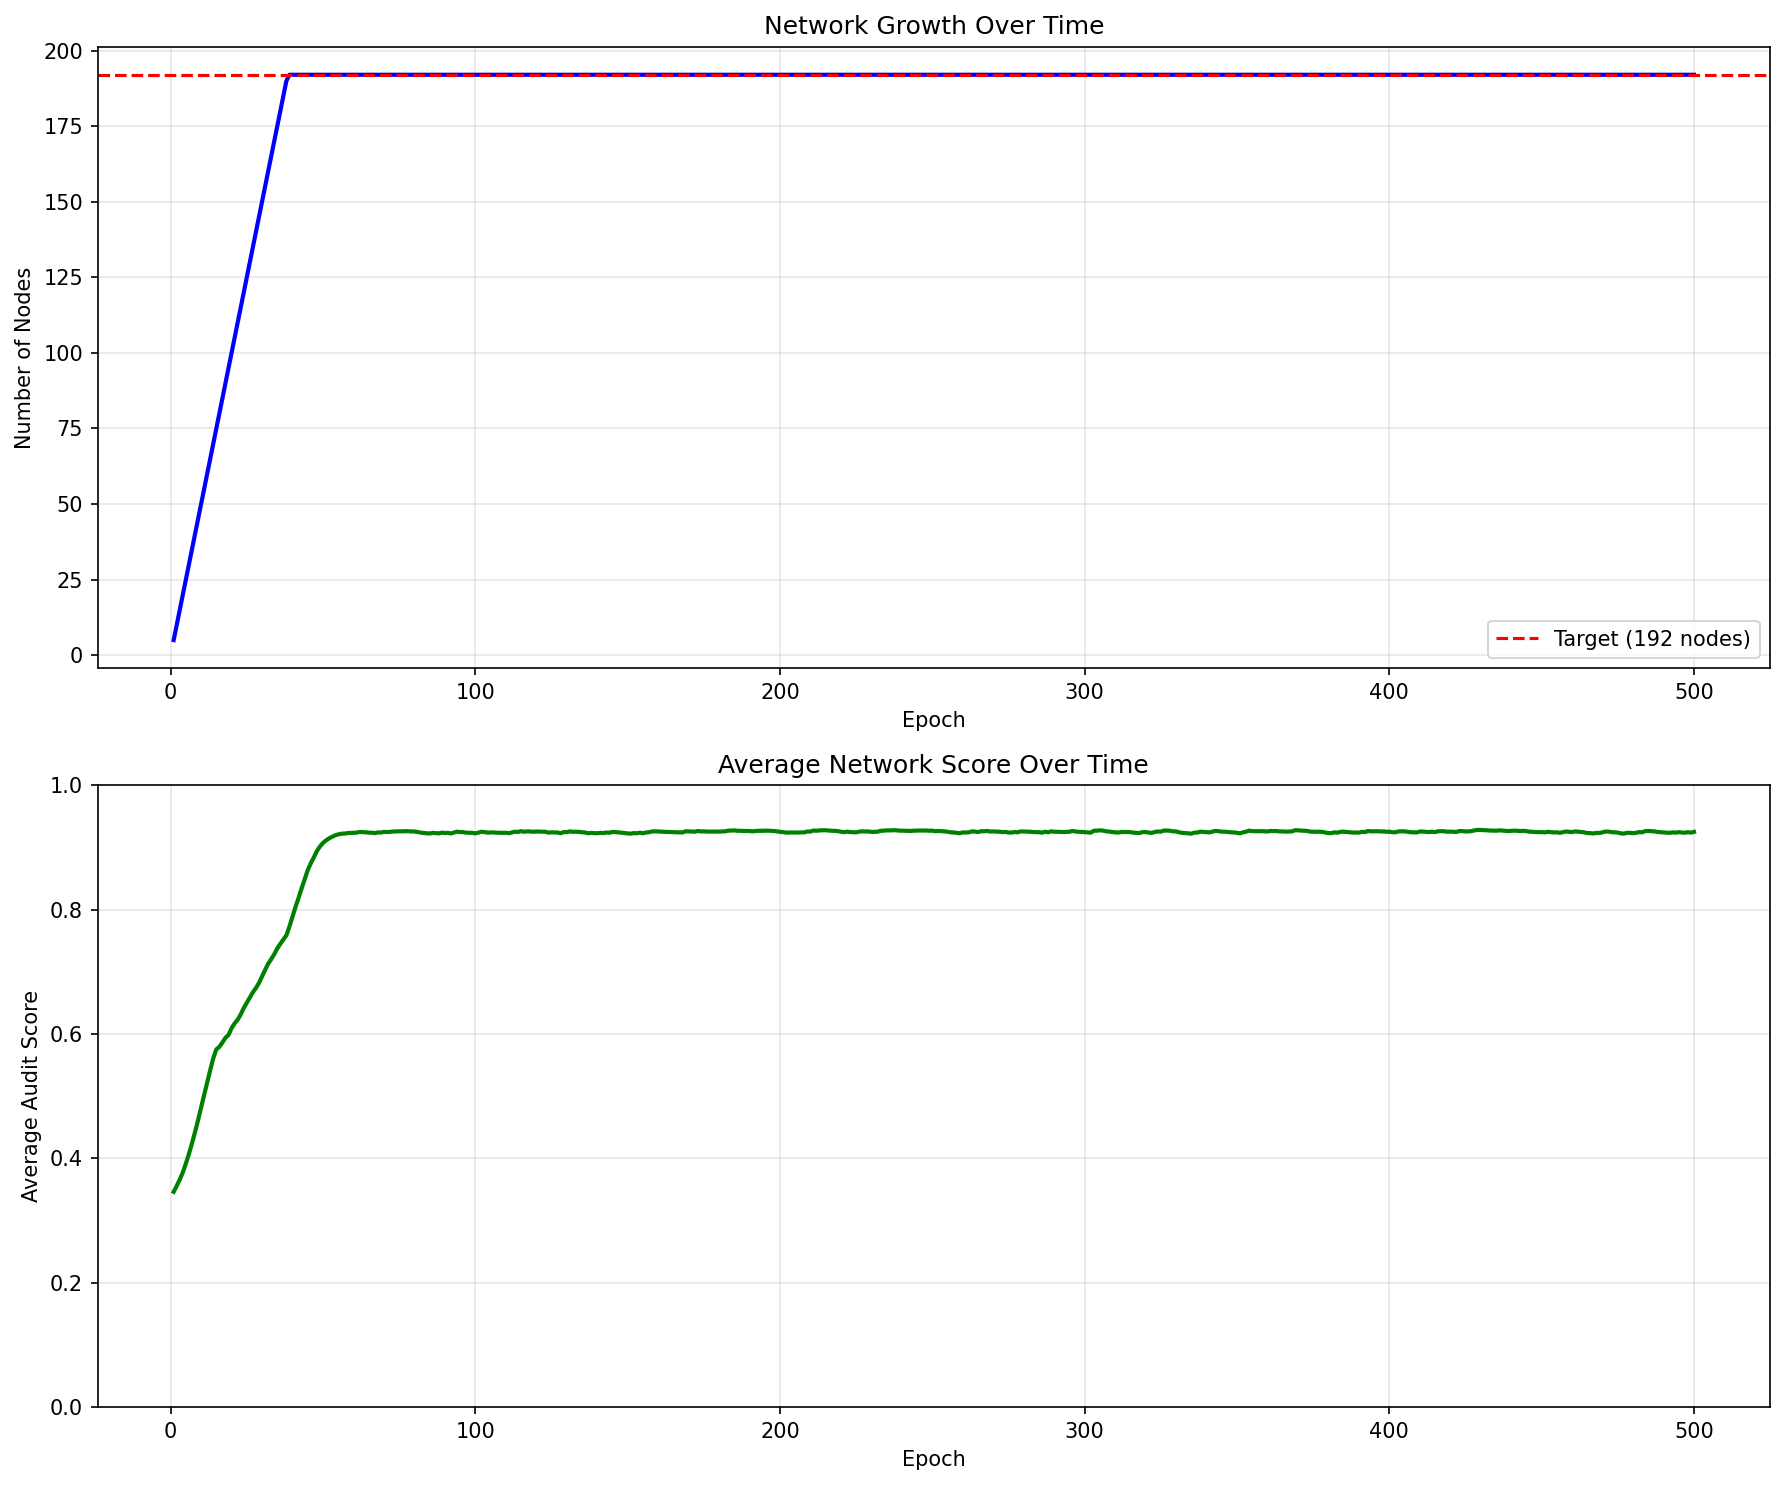


Network Growth Summary:
Final network size: 192 nodes
Target size: 192 nodes
Target reached at epoch: 39
Final average score: 0.9250
Peak average score: 0.9281


In [ ]:
# %%

def analyze_network_growth():
    """Analyze how the network grows from zero nodes"""
    
    config = {
        "num_nodes_target": 192,
        "epochs": 500,  # Shorter simulation to focus on growth
        "audits_per_epoch": 30,
        "nodes_per_epoch_add": 5,  # Faster growth
        "nodes_per_epoch_churn": 2,  # Less aggressive churn
        "min_epochs_before_churn": 15
    }
    
    result = run_notebook_simulation(config)
    epoch_data = result["epoch_data"]
    
    # Extract network size over time
    epochs = [data["epoch"] for data in epoch_data]
    network_sizes = [data["total_nodes"] for data in epoch_data]
    
    # Calculate average scores over time
    avg_scores = []
    for data in epoch_data:
        if data["nodes"]:
            scores = [node["y"] for node in data["nodes"]]
            avg_scores.append(np.mean(scores))
        else:
            avg_scores.append(0)
    
    # Create growth analysis plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Network size over time
    axes[0].plot(epochs, network_sizes, linewidth=2, color="blue")
    axes[0].axhline(y=config["num_nodes_target"], color="red", linestyle="--", 
                   label=f"Target ({config['num_nodes_target']} nodes)")
    axes[0].set_title("Network Growth Over Time")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Number of Nodes")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: Average network score over time
    axes[1].plot(epochs, avg_scores, linewidth=2, color="green")
    axes[1].set_title("Average Network Score Over Time")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Average Audit Score")
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print growth statistics
    final_size = network_sizes[-1]
    target_reached_epoch = None
    for i, size in enumerate(network_sizes):
        if size >= config["num_nodes_target"]:
            target_reached_epoch = epochs[i]
            break
    
    print(f"\nNetwork Growth Summary:")
    print(f"Final network size: {final_size} nodes")
    print(f"Target size: {config['num_nodes_target']} nodes")
    if target_reached_epoch:
        print(f"Target reached at epoch: {target_reached_epoch}")
    print(f"Final average score: {avg_scores[-1]:.4f}")
    print(f"Peak average score: {max(avg_scores):.4f}")

# Analyze network growth
analyze_network_growth()